# Riempimento della DPRAM - piccoli studi

In [1]:
import ROOT as R
import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import scipy

Welcome to JupyROOT 6.16/00


In [2]:
def load_file(path):
    return R.TFile.Open(path)

Ho importato il file su ROOT, così da poter fare qualche studio di correlazione fra la saturazione e altri fattori.

In [3]:
c = R.TCanvas("c")

In [4]:
f=load_file("DPRAM_study_run_376.root")

Il file è lo stesso usato nelle mail

## Andamento del numero di hit per bucket

La variabile "n_hit" contiene il numero di hit per ogni pagina, per ogni GEMROC, per ogni trigger. Non rientrano però nel tree le pagine totalmente vuote. Per questo studio continuo a tenere fuori le planari.

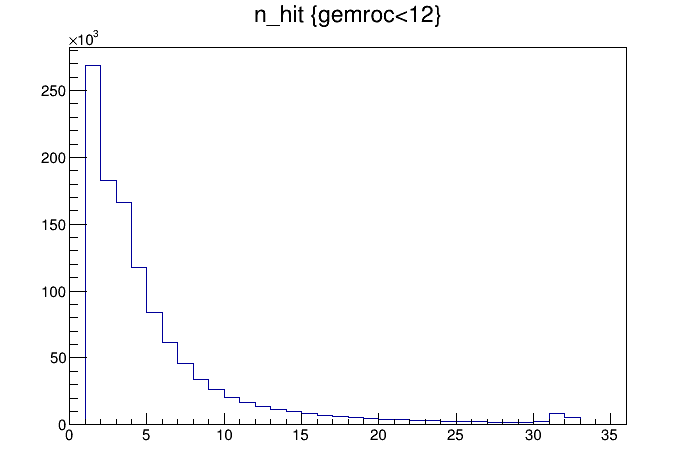

In [5]:
f.tree.Draw("n_hit>>h(36,0,36)","gemroc<12","")
c.Draw("")
R.gStyle.SetOptStat(0)

Si nota che il picco di saturazione non è solo a 32, zoommando:

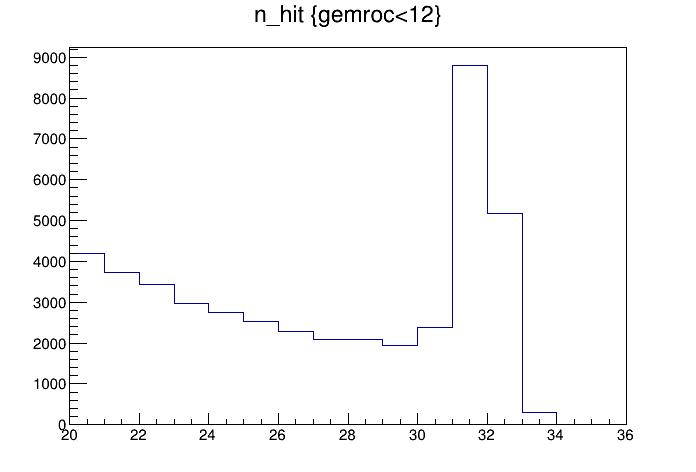

In [6]:
f.tree.Draw("n_hit>>h(16,20,36)","gemroc<12","colz")
c.Draw("")

E' possibile che in qualche modo anche 31 sia un valore di saturazione? (Ovvero che sia più difficile per il sistema arrivare a riempire la 32° posizione?). Si notano anche quei pochi eventi con 33 hit di cui parlavo nella mail, che restano abbastanza inspiegabili per me.

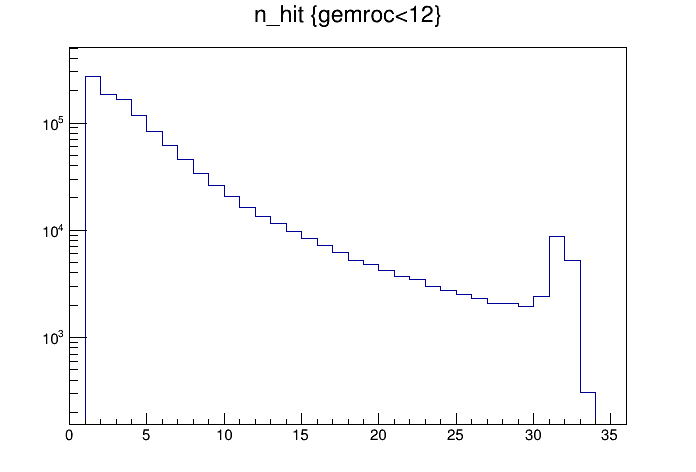

In [7]:
f.tree.Draw("n_hit>>h(36,0,36)","gemroc<12","colz")
c.SetLogy()
c.Draw("")

In scala semilog, sembra esserci un andamento esponenziale a due pendenze. Costruisco un istogramma per andarlo a fittare (In PyRoot non riesco a recuperare l'istogramma riempito con tree.Draw()) con un doppio esponenziale.

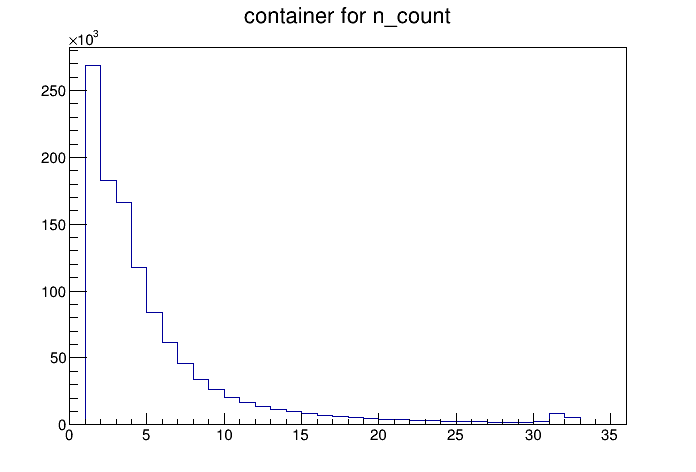

In [137]:
h1= R.TH1I( "h1", 'container for n_count', 36, 0, 36) 
for  entryNum  in  range(0,f.tree.GetEntries ()):
    f.tree.GetEntry(entryNum)
    gemroc=getattr(f.tree ,"gemroc")
    n_hit=getattr(f.tree ,"n_hit")

    if gemroc <11:
       h1.Fill(n_hit)
h1.Draw()
c.Draw()

 FCN=4654.02 FROM MIGRAD    STATUS=CONVERGED     576 CALLS         577 TOTAL
                     EDM=3.37916e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.12411e+05   8.07093e+02   1.47076e+01   3.98160e-07
   2  p1           3.12346e-01   8.49267e-04   7.55818e-06  -9.54391e-01
   3  p2           1.19359e+04   4.04358e+02   1.66852e+00  -5.54954e-06
   4  p3           6.17904e-02   1.39882e-03   7.23357e-06   2.40523e+00


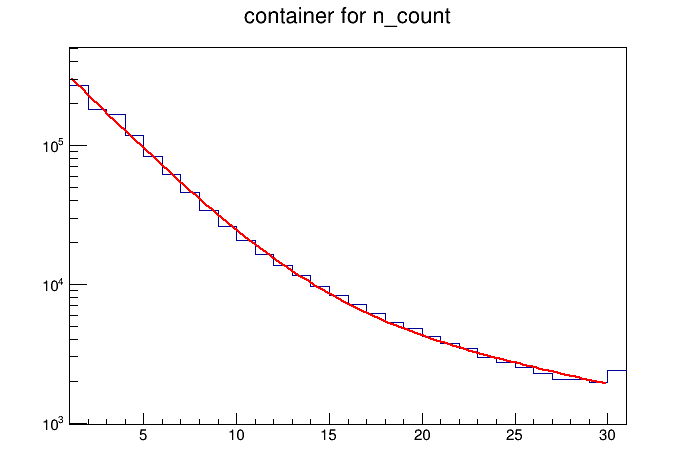

In [9]:
func = R.TF1('func', '[0]*TMath::Exp(-x*[1])+ [2]*TMath::Exp(-x*[3])', 1, 34)
func.SetParameters(11000,0.06,41000,0.3)
h1.Fit('func',"","",1,30)
h1.Draw()
c.Draw()
c.SetLogy(1)
h1.SetAxisRange(1,30,"X")

In [10]:
fit = h1.GetFunction("func")

In [11]:
fit.GetChisquare()

4654.015821456513

In [12]:
fit.GetNDF()

25

Senza alcuna velleità di aver fatto un lavoro statisticamente corretto (si vede già dal chi quadro), guardo comunque l'integrale nel range fittato rispetto a quello dell'istogramma nello stesso range:

In [13]:
print (h1.Integral (1,30)/func.Integral(1,30))

1.0006390881741345


Che sembra in buon accordo, e quello fra 1 e "infinito"

In [14]:
h1.Integral (1,1000)/func.Integral(1,1000)

0.9886908590958854

Prendendolo con le dovute pinze, la perdita dei dati dovrebbe essere poco sopra l'1%

## Andamento del numero di hit in relazione ad altri fattori

Con le planari. Cominciamo controllando che il riempimento dei bucket sia uniforme

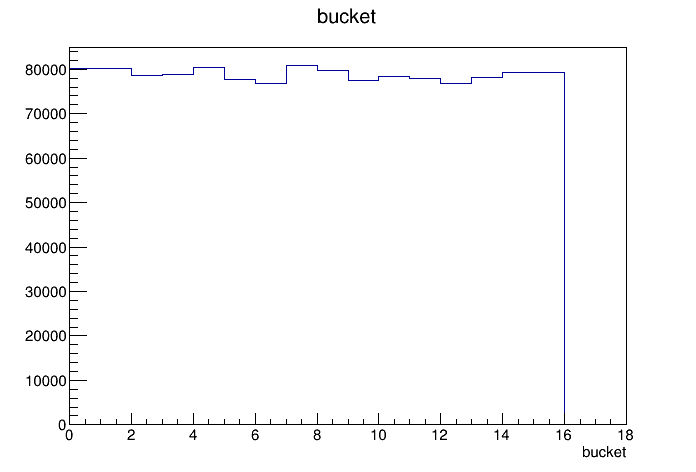

In [15]:
f.tree.Draw("bucket")
c.SetLogy(0)
c.Draw()

Il numero di hit per bucket semra abbastanza uniforme. Non sembrano esserci problemi di efficienza in funzione del bucket. 


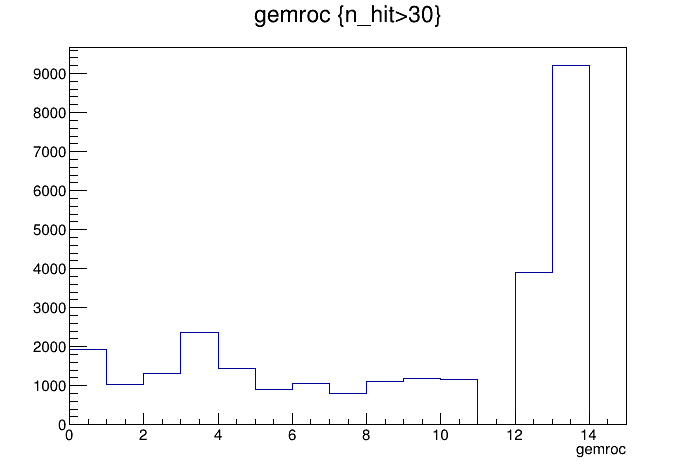

In [16]:
f.tree.Draw("gemroc","n_hit>30")
c.Draw()

Il numero di pagine saturate è molto maggiore sulle planari (soglie impostate con il metodo delle sigma). Confrontando L1 e L2:

In [17]:
Tot_l1=f.tree.Draw("gemroc","n_hit>30 && gemroc<4")


In [18]:
Tot_l2=f.tree.Draw("gemroc","n_hit>30 && gemroc>3 && gemroc<11")


In [19]:
print (f'Totale L1={Tot_l1}, Totale L2={Tot_l2}, per GEMROC L1={Tot_l1/4}. per GEMROC L2={Tot_l2/7}')

Totale L1=6634, Totale L2=7663, per GEMROC L1=1658.5. per GEMROC L2=1094.7142857142858


In rapport al numero di GEMROC, L1 sembra saturate di più. Il rate in questo run era impostato a 5kHz e misurato intorno a 3 kHz per entrambi.

## Andamento del numero di hit in relazione alle soglie
Ho provato a far girare lo script su altri run con impostazioni di soglie differenti per vedere se ci sono differenze di comportamento. La figura di riferimento continua a essere l'andamento del n° di hit per pagina.

In [20]:
f2 = load_file("DPRAM_study_run_395.root")

Questo è un run di prova (molto corto), acquisito con le soglie fisse (a 6fC e 12fC, quindi molto alte).

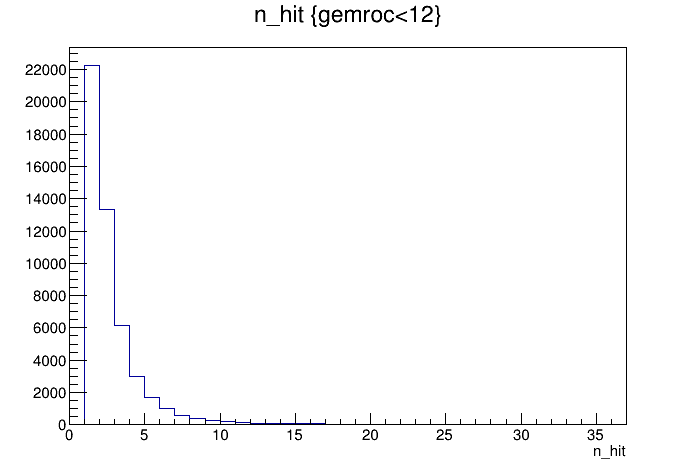

In [21]:
f2.tree.Draw("n_hit","gemroc<12")
c.Draw()

Le pagine sono sempre quasi vuote, come si può aspettare con soglie così alte. I rate per canale sono di circa 150 Hz per L1 e 300 Hz per L2, per altro dettati da pochi canali a decine kHz e tutto gli altri a pochi Hz.

In [22]:
f3 = load_file("DPRAM_study_run_375.root")

Questa è un'acquisizione effettuata la settimana prima del 376, con soglie impostate a 10kHz.

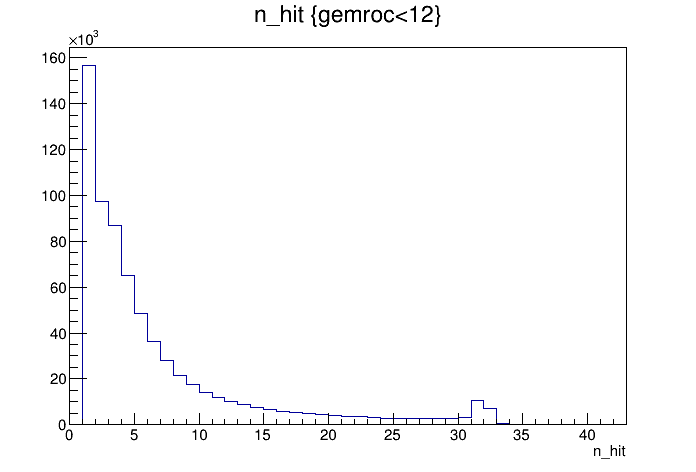

In [23]:
f3.tree.Draw("n_hit","gemroc<12")
c.Draw()

Faccio due istogrammi per normalizzare e confrontarli

In [24]:
h376= R.TH1D( "h376", 'container for n_count', 36, 0, 36) 
for  entryNum  in  range(0,f.tree.GetEntries ()):
    f.tree.GetEntry(entryNum)
    gemroc=getattr(f.tree ,"gemroc")
    n_hit=getattr(f.tree ,"n_hit")
    if gemroc <11:
       h376.Fill(n_hit)

In [25]:
h375= R.TH1D( "h375", 'container for n_count', 36, 0, 36) 
for  entryNum  in  range(0,f3.tree.GetEntries ()):
    f3.tree.GetEntry(entryNum)
    gemroc=getattr(f3.tree ,"gemroc")
    n_hit=getattr(f3.tree ,"n_hit")
    if gemroc <11:
       h375.Fill(n_hit)

In [26]:
norm = h375.GetEntries()
h375.Scale(1/norm)
norm = h376.GetEntries()
h376.Scale(1/norm)

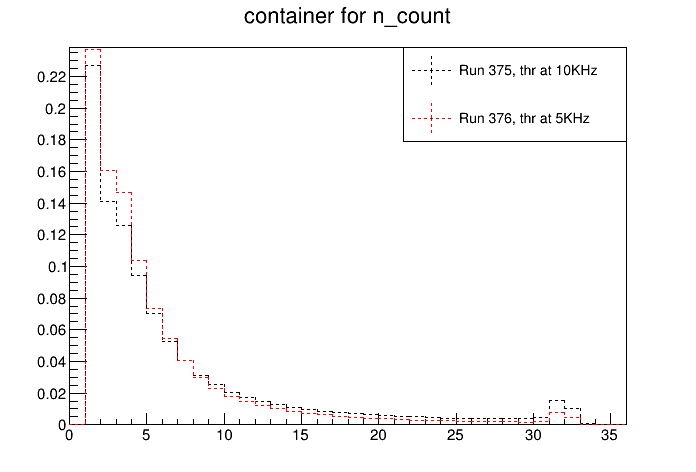

In [27]:
h375.Draw("histo ")
h375.SetLineColor(1)
h375.SetLineStyle(2)
h376.Draw("histo same")
h376.SetLineColor(2)
h376.SetLineStyle(2)

leg=R.TLegend(0.58,0.7,0.9,0.9);
leg.AddEntry("h375","Run 375, thr at 10KHz","lep")
leg.AddEntry("h376","Run 376, thr at 5KHz","lep")
leg.Draw()
c.Draw("")

Come atteso, la saturazione è meno presente nel run acquisito a 5kHz.

## Saturazione vs noise

Carico uno scan di noise e lo divido per FEB

In [28]:
noise_f=load_file("/home/alb/Noise_analysis/branch_T_23_marzo_2020.root")

In [29]:
hnoise= R.TH2D( "hnoise", 'Noise per FEB',44,0,44,100,0,8) 
for  entryNum  in  range(0,noise_f.tree.GetEntries ()):
    noise_f.tree.GetEntry(entryNum)
    noise_lvl=getattr(noise_f.tree ,"noise_lvl")
    tiger_id=getattr(noise_f.tree ,"tiger_id")
    gemroc_id=getattr(noise_f.tree ,"gemroc_id")
    if gemroc_id <11:
       hnoise.Fill(gemroc_id*4+tiger_id//2, noise_lvl)

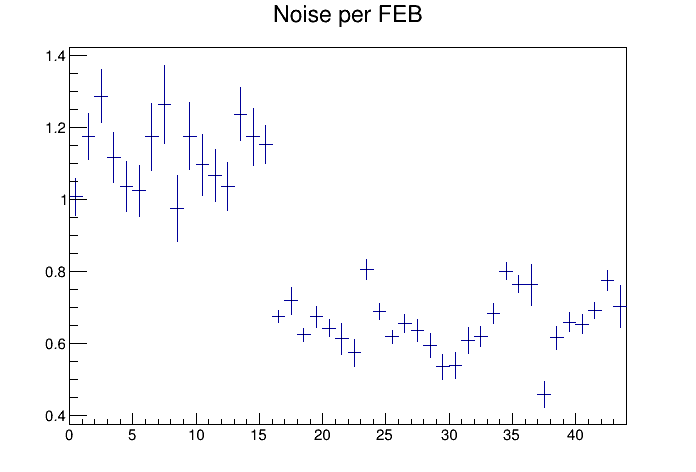

In [30]:
hprof= hnoise.ProfileX()
hprof.Draw("*")
c.Draw()

L'errore sul profilo è dato dal normale errore sulla media.

In [31]:
norm = hprof.Integral(0,45)
hprof.Scale(1/norm)

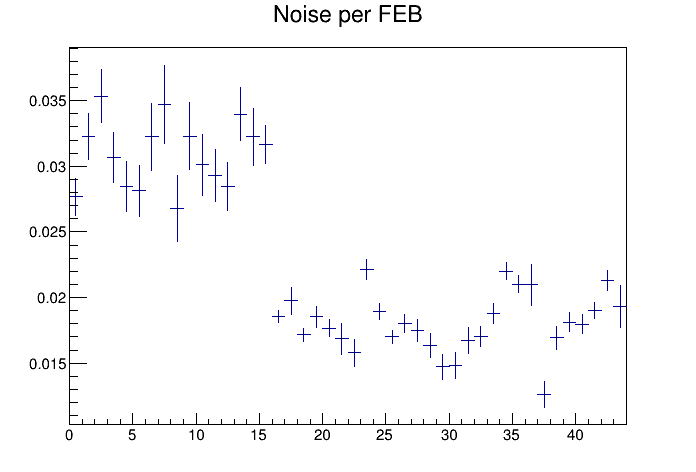

In [32]:
hprof.Draw()
c.Draw()

Prendo il run 376, estraggo il numero di saturazioni per FEB e provo a sovrapporlo al noise per farmi una prima idea.

In [33]:
h1d_376= R.TH1D( "h1d_376", 'Count>30 per FEB',44,0,44) 
for  entryNum  in  range(0,f.tree.GetEntries ()):
    f.tree.GetEntry(entryNum)
    gemroc=getattr(f.tree ,"gemroc")
    n_hit=getattr(f.tree ,"n_hit")
    feb=getattr(f.tree ,"feb")

    if gemroc <11 and n_hit>30:
        h1d_376.Fill(gemroc*4+feb)

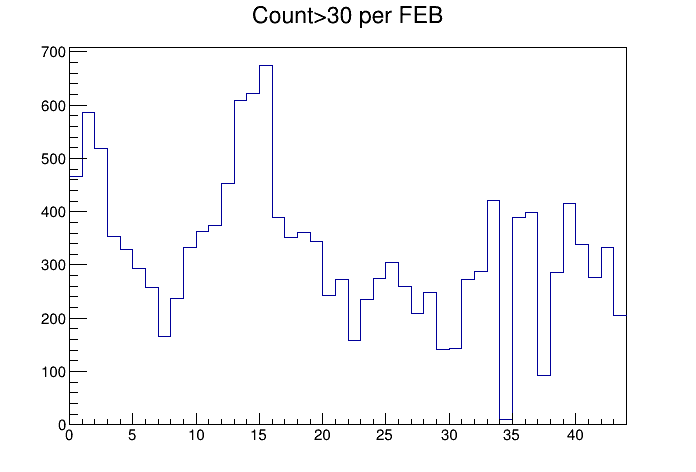

In [34]:
h1d_376.Draw()
c.Draw()

In [35]:
norm = h1d_376.GetEntries()
h1d_376.Scale(1/norm)

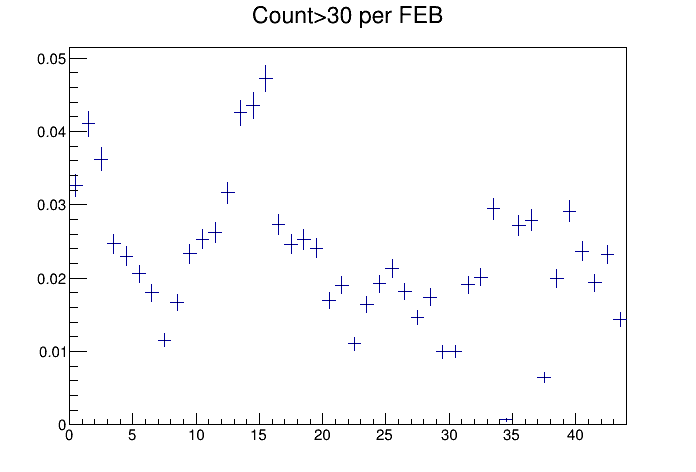

In [36]:
h1d_376.Draw()
c.Draw()

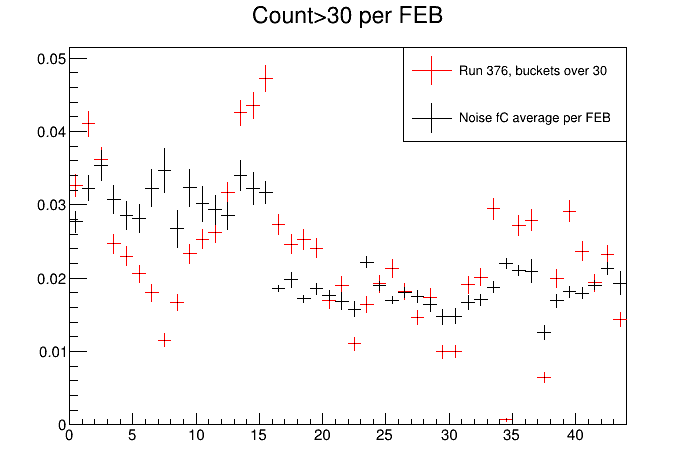

In [37]:
h1d_376.Draw(" ")
h1d_376.SetLineColor(2)
hprof.Draw( "same")
hprof.SetLineColor(1)

leg2=R.TLegend(0.58,0.7,0.9,0.9);
leg2.AddEntry("h1d_376","Run 376, buckets over 30","El")
leg2.AddEntry("hprof","Noise fC average per FEB","El")
leg2.Draw()
c.Draw("")

Sembra seguire abbastanza l'andamento del noise in fC. Proviamo a vederemetterli in relazione.

In [38]:
h1d_376_2= R.TH1D( "h1d_376_2", 'Count>30 per FEB',45,0,44) 
for  entryNum  in  range(0,f.tree.GetEntries ()):
    f.tree.GetEntry(entryNum)
    gemroc=getattr(f.tree ,"gemroc")
    n_hit=getattr(f.tree ,"n_hit")
    feb=getattr(f.tree ,"feb")

    if gemroc <11 and n_hit>30:
        h1d_376_2.Fill(gemroc*4+feb)

In [39]:
hprof2= hnoise.ProfileX()


In [40]:
hit_vs_noise= R.TGraphErrors(44)

In [41]:
for FEB in range (0,45):
    hit_vs_noise.SetPoint(FEB,h1d_376_2.GetBinContent(FEB),hprof2.GetBinContent(FEB))
    hit_vs_noise.SetPointError(FEB,h1d_376_2.GetBinError(FEB),hprof2.GetBinError(FEB))

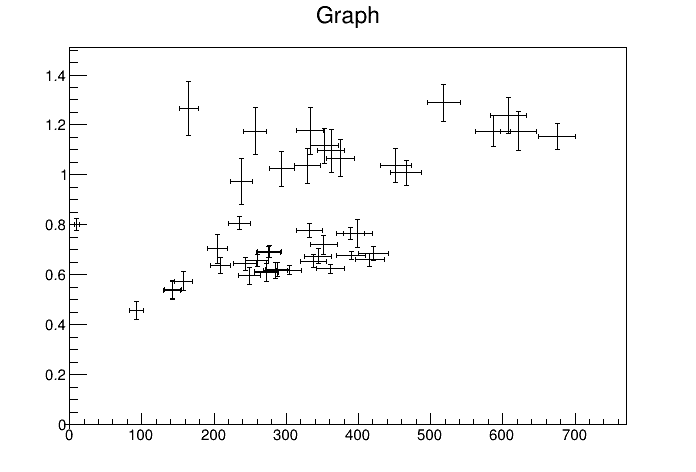

In [42]:
hit_vs_noise.SetMarkerStyle(2)
hit_vs_noise.Draw("AP")
c.Draw()

L'errore in x è dato dal numero di conteggi, quello y dall'errore sulla media. Dividendo per L1 e L2.

In [43]:
mg=R.TMultiGraph()


In [44]:
hit_vs_noise1= R.TGraphErrors(16)
hit_vs_noise2= R.TGraphErrors(28)

In [51]:
for FEB in range (1,45):
    if FEB <17:
        hit_vs_noise1.SetPoint(FEB,h1d_376_2.GetBinContent(FEB),hprof.GetBinContent(FEB))
        hit_vs_noise1.SetPointError(FEB,h1d_376_2.GetBinError(FEB),hprof.GetBinError(FEB))
    else: 
        hit_vs_noise2.SetPoint(FEB-16,h1d_376_2.GetBinContent(FEB),hprof.GetBinContent(FEB))
        hit_vs_noise2.SetPointError(FEB-16,h1d_376_2.GetBinError(FEB),hprof.GetBinError(FEB))

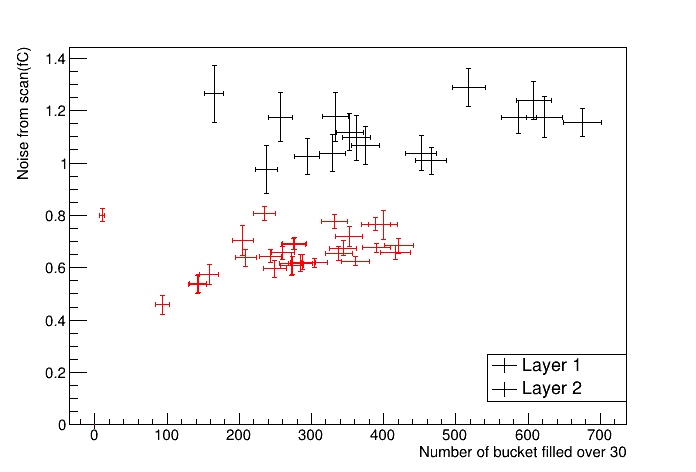

In [136]:
leg3=R.TLegend(0.7,0.15,0.9,0.25);

hit_vs_noise1.SetMarkerStyle(2)
hit_vs_noise1.SetMarkerColor(1)
hit_vs_noise2.SetMarkerStyle(2)
hit_vs_noise2.SetMarkerColor(2)
hit_vs_noise2.SetLineColor(2)
hit_vs_noise2.SetLineColor(R.kRed);
hit_vs_noise2.SetLineWidth(1);
hit_vs_noise2.SetMarkerStyle(1);
hit_vs_noise2.SetMarkerSize(1.3);
hit_vs_noise2.SetMarkerColor(2);
hit_vs_noise2.Draw("P");
leg3.AddEntry("hit_vs_noise1","Layer 1","EL")
hit_vs_noise2.Draw("AP")
leg3.AddEntry("hit_vs_noise2","Layer 2","EL")

mg.Add(hit_vs_noise1)
mg.Add(hit_vs_noise2)
mg.GetXaxis().SetTitle("Number of bucket filled over 30")
mg.GetYaxis().SetTitle("Noise from scan(fC)")
mg.Draw("AP")
leg3.Draw()


c.Draw()

Layer 2 in rosso (non sono riuscito a far funzionare la legenda).
Il punto a 0,0.8 è la FEB 34, ovvero la FEB 2 di GEMROC 8, funzionante nello scan di soglia, ma disattivata in acquisizione a causa dei suoi problemi di instabilità nell'alimentazione analogica.
Dal plot è chiara la dipendenza sia dal layer, sia dal livello di noise in fC, nonostante le soglie siano impostate allo stesso rate. La mia ipotesi è che a livelli di noise maggiori corrisponde una maggiore clusterizzazione in tempo del noise.

# Conclusioni

Il problema di saturazione "hard" (ovvero 31 + hit in un bucket) non sembra troppo rilevate. Sembra dipendere da soglie e noise, come ragionevole. Può essere interessante comprendere il perchè della saturazione a 31. In futuro indagherò le situazioni risky (in cui la % di memoria occupata è >= alla percentuale di memoria letta dal trigger).